In [9]:
# Importing necessary libraries (see configuration file .yml in github repo)
#!pip install pybdshadow contextily folium pillow timezonefinder plotly

In [10]:
# Library Imports
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
#from statsmodels.tsa.api import VAR
#from statsmodels.tsa.stattools import adfuller, grangercausalitytests
#from statsmodels.tools.eval_measures import rmse, aic
#from statsmodels.tsa.vector_ar.vecm import coint_johansen
#from statsmodels.stats.stattools import durbin_watson
#import folium
import geopandas as gpd
from shapely.geometry import Polygon
#import pytz
#import pybdshadow
#from timezonefinder import TimezoneFinder
#import json
#import seaborn as sns
#from tabulate import tabulate
#import plotly.express as px
#from sklearn.mixture import GaussianMixture
#import pickle
import os

from suncalc import get_position
from pyproj import CRS,Transformer

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D,MaxPooling1D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

In [11]:
class ShadowModule:
        
    def __init__(self,lat, lon, roofs, spaces):
        self.lat= lat
        self.lon= lon
        self.roofs = roofs
        self.spaces= spaces
    
    
    def compute_coverage_rates(self, days_lst):
        """
        Compute coverage rates for each day in days_lst
        """

        # DataFrames to store results
        coverage_rates_df = pd.DataFrame()

        for current_date in days_lst:
            # Compute shadow projections for roofs
            shadows = self._all_sunshadeshadow_sunlight(current_date)

            # Calculate coverage rates
            coverage_rates = []
            for index, parking_space in self.spaces.iterrows():
                parking_space_gdf = gpd.GeoDataFrame(geometry=[parking_space.geometry])
                parking_space_gdf = parking_space_gdf.set_crs(epsg=4326)
                parking_space_gdf = parking_space_gdf.to_crs(epsg=shadows.crs.to_epsg())

                intersection = gpd.overlay(parking_space_gdf, shadows, how='intersection')

                intersection_area = intersection.geometry.area.sum()
                parking_space_area = parking_space_gdf.geometry.area.sum()

                coverage_rate = intersection_area / parking_space_area
                coverage_rates.append(coverage_rate)

            coverage_rates_df[f'coverage_rate_{current_date.strftime("%Y-%m-%d %H:%M:%S")}'] = coverage_rates

        return coverage_rates_df

        # Define function to calculate shadow and sunlight for all rooftops
    def _all_sunshadeshadow_sunlight(self, date):
        roof_projected_df= self.roofs
        print(roof_projected_df)
        roof_projected_df['geometry'] = roof_projected_df['geometry'].apply(lambda r: self._sunshadeshadow_sunlight(date, r))
        return roof_projected_df


    def _sunshadeshadow_sunlight(self, date, r, sunshade_height=2):
        print(date, r)
        meanlon= r.centroid.x
        meanlat= r.centroid.y
        # obtain sun position
        sunPosition = get_position(date, meanlon, meanlat)
        if sunPosition['altitude'] < 0:
            raise ValueError("Given time before sunrise or after sunset")
            
        r_coords= np.array(r.exterior.coords)
        r_coords= r_coords.reshape(1,-1,2)
        shape = ShadowModule.lonlat2aeqd(r_coords,meanlon,meanlat)
        azimuth = sunPosition['azimuth']
        altitude = sunPosition['altitude']

        n = np.shape(shape)[0]
        distance = sunshade_height / math.tan(altitude)

        # calculate the offset of the projection position
        lonDistance = distance * math.sin(azimuth)
        latDistance = distance * math.cos(azimuth)

        shadowShape = np.zeros((1, 5, 2))
        shadowShape[:, :, :] += shape
        shadowShape[:, :, 0] = shape[:, :, 0] + lonDistance
        shadowShape[:, :, 1] = shape[:, :, 1] + latDistance
        shadowShape = ShadowModule.aeqd2lonlat(shadowShape,meanlon,meanlat)
        p = Polygon([[p[0], p[1]] for p in shadowShape[0]])
        return p
    
    @staticmethod
    def lonlat2aeqd(lonlat, center_lon, center_lat):
        epsg = CRS.from_proj4("+proj=aeqd +lat_0="+str(center_lat) +
                            " +lon_0="+str(center_lon)+" +datum=WGS84")
        transformer = Transformer.from_crs("EPSG:4326", epsg, always_xy=True)
        proj_coords = transformer.transform(lonlat[:, :, 0], lonlat[:, :, 1])
        proj_coords = np.array(proj_coords).transpose([1, 2, 0])
        return proj_coords
    
    @staticmethod
    def aeqd2lonlat(proj_coords,meanlon,meanlat):
        epsg = CRS.from_proj4("+proj=aeqd +lat_0="+str(meanlat)+" +lon_0="+str(meanlon)+" +datum=WGS84")
        transformer = Transformer.from_crs( epsg,"EPSG:4326",always_xy = True)
        lonlat = transformer.transform(proj_coords[:,:,0], proj_coords[:,:,1])
        lonlat = np.array(lonlat).transpose([1,2,0])
        return lonlat



In [12]:
class DemandModule:
    def __init__(self, entry_exit_tuples):        
        self._entry_exit_tuples= entry_exit_tuples

    def train_demand_predictors(self, lr=0.9, sequence_length= 12, show_details=True, refresh_model=False):
        self._sequence_length= sequence_length

        #self._gm = GaussianMixture(n_components=self._n_components, random_state=42)
        #self._gm.fit(self._entry_exit_tuples[['enter_hour', 'exit_hour']])

        self._gmm_models={}
        for hour, group in self._entry_exit_tuples.groupby('enter_hour'):
            X = group["exit_hour"].values  # Extraer los datos de las características para este grupo
            if X.shape[0]== 1:
                X= X.reshape(1, -1)
            else:
                X= X.reshape(-1,1)
            if X.shape[0]>=2:
                # Crear y ajustar el modelo GMM; ajusta n_components según tus necesidades
                gmm = GaussianMixture(n_components=1, random_state=42)
                gmm.fit(X)
                self._gmm_models[hour] = gmm

        model_path = os.path.join('_models', 'demand_cnnlstm_model.keras')
        # Cargamos o entrenamos el modelo

        n_incoming_veh_df= self._entry_exit_tuples.groupby('date').size().reset_index()
        n_incoming_veh_df['datetime'] = pd.to_datetime(n_incoming_veh_df['date'])

        # Establecer 'datetime' como índice
        n_incoming_veh_df.set_index('datetime', inplace=True)

        # Renombrar la columna 'num_vehicles'
        n_incoming_veh_df.rename(columns={0: "num_vehicles"}, inplace=True)

        # Eliminar columnas originales si ya no se necesitan
        n_incoming_veh_df.drop(columns=["date"], inplace=True)

        self._scaler = MinMaxScaler()
        n_incoming_veh_df['num_vehicles'] = self._scaler.fit_transform(n_incoming_veh_df[['num_vehicles']])

        values = n_incoming_veh_df['num_vehicles'].values
        X, y = self._create_unidimensional_sequences(values, self._sequence_length)

        # Dividir los datos en conjunto de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-lr, random_state=42)

        # Cambiar la forma de los datos para adaptarse a la entrada CNN-LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        self._last_sequence = X_test[-1].flatten() 

        if os.path.exists(model_path) and not refresh_model:
            print(f"\n\tLoading demand predictor from {model_path}...", end="")
            self._model = load_model(model_path)
        else: 
            print(f"\n\tTraining demand predictor...", end="")

            # Definir el modelo CNN-LSTM
            self._model = Sequential([
                Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
                MaxPooling1D(pool_size=2),
                LSTM(50, activation='relu', return_sequences=False),
                Dense(1)
            ])

            self._model.compile(optimizer='adam', loss='mse')

            _verbose= 0
            if show_details:
                _verbose= 1
            # Configuración de EarlyStopping
            early_stopping = EarlyStopping(
                monitor="val_loss",  # Métrica que se monitorea
                patience=10,         # Número de épocas de espera sin mejoras antes de detener
                restore_best_weights=True,  # Restaurar los mejores pesos
                verbose=_verbose          # Mostrar mensajes
            )

            # Entrenamiento con EarlyStopping
            self._model.fit(
                X_train,
                y_train,
                epochs=1000,
                batch_size=16,
                validation_data=(X_test, y_test),
                callbacks=[early_stopping],  # Incluir el callback
                verbose=1
            )
            
            self._model.save(model_path)

        print("DONE!")

    # Crear los datos de entrada y salida para la serie temporal
    def _create_unidimensional_sequences(self, data, sequence_length):
        X, y = [], []
        for i in range(len(data) - sequence_length):
            X.append(data[i:i + sequence_length])
            y.append(data[i + sequence_length])
        return np.array(X), np.array(y)
    
    def _predict_occupancy(self, n_days_ahead):

        future_predictions = []
        current_sequence = self._last_sequence.copy()

        for _ in range(n_days_ahead*24):
            # Redimensionar la secuencia actual para que sea compatible con el modelo
            input_data = np.array(current_sequence).reshape((1, self._sequence_length, 1))
            
            # Predecir el siguiente valor
            next_pred = self._model.predict(input_data, verbose=0)[0][0]
            
            # Guardar el valor predicho (desnormalizado)
            future_predictions.append(self._scaler.inverse_transform([[next_pred]])[0][0])

            # Actualizar la secuencia de entrada con la nueva predicción
            current_sequence = np.append(current_sequence[1:], next_pred)

        return future_predictions

    def _generate_entry_and_exit_hours(self, n_tuples):
        new_samples, _ = gm.sample(n_samples=n_tuples)
        return [[round(x[0]),round(x[1])] for x in new_samples]
    
    def generate_occupancy(self, num_days_ahead):
        """
        Simulates vehicle parking occupancy and generates a table of occupancy information.
        """

        n_vehicles_per_hour = self._predict_occupancy(num_days_ahead)
        print("n_vehicles_per_hour", len(n_vehicles_per_hour))
        simulated_occupancy=[]
        hour= 0
        for n_vehicles in n_vehicles_per_hour: 
            if hour in self._gmm_models:
                gm = self._gmm_models[hour]      
                new_samples, _ = gm.sample(n_samples=n_vehicles)
                simulated_occupancy.append([(hour, round(x[0])) for x in new_samples])
            hour = (hour+1) % 24
        return simulated_occupancy 

In [13]:
class AmbientModule:
    
    def __init__(self, lat, lon):
        self.lat= lat
        self.lon= lon

    def train_ambient_temperature_model(self, start_date, end_date, lr=0.9, show_details=False, refresh_model=False):
        """
        Trains a LSTM model using the combined temperature data.

        :param combined_temp_data: DataFrame containing combined temperature data
        """

        ambient_temperaure_df= self._fetch_historical_temperature(start_date, end_date)
        model_path = os.path.join('_models', 'cabintemp_lstm_model.keras')

        # Normalización de los datos
        scaler = MinMaxScaler(feature_range=(0, 1))
        #scaler_b = MinMaxScaler(feature_range=(0, 1))

        data = ambient_temperaure_df.copy()
        data["temperature_2m"] = scaler.fit_transform(ambient_temperaure_df["temperature_2m"].values.reshape(-1, 1))

        look_back = 12  # Número de pasos anteriores a considerar
        X, y = ClimaticPark.create_sequences(data.values, look_back)

        # Dividimos en entrenamiento y prueba
        train_size = int(len(X) * lr)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # Redimensionamos las entradas para LSTM [samples, time steps, features]
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        self._last_sequence = X_test[-1].flatten() 
        
        model = None
        # Cargamos o entrenamos el modelo
        if os.path.exists(model_path) and not refresh_model:
            print(f"\n\tLoading ambient temperature predictor from {model_path}...", end="")
            model = load_model(model_path)
            print("DONE!")
        else:
            print(f"\n\tTraining and saving model in {model_path}...")

            _verbose= 0
            if show_details:
              _verbose= 1
            # Configuración de EarlyStopping
            early_stopping = EarlyStopping(
                monitor="val_loss",  # Métrica que se monitorea
                patience=10,         # Número de épocas de espera sin mejoras antes de detener
                restore_best_weights=True,  # Restaurar los mejores pesos
                verbose=_verbose           # Mostrar mensajes
            )


            # Construcción del modelo LSTM
            model = Sequential()
            model.add(LSTM(50, input_shape=(look_back, 1)))
            model.add(Dense(1))
            model.compile(optimizer="adam", loss="mse")

            # Entrenamiento con EarlyStopping
            model.fit(
                X_train,
                y_train,
                epochs=1000,
                batch_size=16,
                validation_data=(X_test, y_test),
                callbacks=[early_stopping],  # Incluir el callback
                verbose=1
            )
            self._last_sequence = X_test[-1].flatten() 

        model.save(model_path)

        self._model= model
        self._scaler= scaler

    def predict_ambient_temperature(self, n_days_ahead):

        future_predictions = []
        current_sequence = self._last_sequence.copy()

        for _ in range(n_days_ahead*24):
            # Redimensionar la secuencia actual para que sea compatible con el modelo
            input_data = np.array(current_sequence).reshape((1, len(current_sequence), 1))
            
            # Predecir el siguiente valor
            next_pred = self._model.predict(input_data, verbose=0)[0][0]
            
            # Guardar el valor predicho (desnormalizado)
            future_predictions.append(self._scaler.inverse_transform([[next_pred]])[0][0])

            # Actualizar la secuencia de entrada con la nueva predicción
            current_sequence = np.append(current_sequence[1:], next_pred)

        return future_predictions

    # Función para obtener datos horarios históricos de Open-Meteo API
    def _fetch_historical_temperature(self, start_date, end_date):
          """
          Obtiene datos horarios históricos de Open-Meteo API.

          Args:
          - latitude (float): Latitud de la ubicación.
          - longitude (float): Longitud de la ubicación.
          - start_date (str): Fecha de inicio en formato YYYY-MM-DD.
          - end_date (str): Fecha de fin en formato YYYY-MM-DD.
          - parameters (list): Variables meteorológicas a consultar, ej. ['temperature_2m', 'humidity_2m'].

          Returns:
          - pd.DataFrame: Datos meteorológicos horarios como DataFrame.
          """
          base_url = "https://archive-api.open-meteo.com/v1/archive"


          # Crear el payload para la solicitud
          payload = {
              "latitude": self.lat,
              "longitude": self.lon,
              "start_date": start_date,
              "end_date": end_date,
              "hourly": 'temperature_2m',
              "timezone": "auto"
          }

          # Realizar la solicitud a la API
          response = requests.get(base_url, params=payload)

          if response.status_code == 200:
              # Convertir la respuesta JSON a un DataFrame
              data = response.json()
              if "hourly" in data:
                  df = pd.DataFrame(data["hourly"])
                  df['time'] = pd.to_datetime(df['time'])
                  df= df.set_index('time')
                  return df
              else:
                  print("No se encontraron datos en la respuesta.")
                  return pd.DataFrame()
          else:
              print(f"Error en la solicitud: {response.status_code} - {response.text}")
              return pd.DataFrame()
          

    def _forecast_uncovered_cabin_temperatures(self, ambient_temp):
        ambient_temp_scaled = self.temp_scaler.fit_transform(ambient_temp)
        y_pred = self.cabin_temp_model.predict(ambient_temp_scaled)
        y_pred_rescaled = self.cabin_temp_scaler.inverse_transform(y_pred)
        return y_pred_rescaled

In [ ]:
class ClimaticPark:
    def __init__(self, file_name_lots='data/parking_lots.geojson',
                 file_name_roofs='data/parking_roofs.geojson',
                 file_name_coords='data/parking_coordinates.csv',
                 file_name_gates='data/gates_coordinates.csv',
                 file_name_mapcenter='data/map_center_coordinates.csv',
                 file_name_cabintem='data/historical_cabin_temp.csv',
                 file_name_tuples='data/entry_exit_tuples.csv'):
        """
        Initializes the ClimaticPark object by loading all necessary files.
        """
        # Load GeoJSON files for lots and roofs
        self.lots_data = ClimaticPark.load_geojson(file_name_lots)
        self.roofs_data = ClimaticPark.load_geojson(file_name_roofs)

        # Add 'height' column to roofs_data with a value of 1 for all rows
        if (self.lots_data is not None) and ('height' not in self.lots_data.columns):
            self.lots_data['height'] = 1  # Assuming a default height of 1

        # Add 'height' column to roofs_data with a value of 1 for all rows
        if (self.roofs_data is not None) and ('height' not in self.roofs_data.columns):
            self.roofs_data['height'] = 1  # Assuming a default height of 1

        # Load CSV files for coordinates, historical data, and additional data
        self.coords_data = ClimaticPark.load_csv(file_name_coords)
        self.gates_data = ClimaticPark.load_csv(file_name_gates)
      
        self.data_no_roof =  ClimaticPark.load_csv(os.path.join('data', 'cabin_temperature_no_roof.csv'))
        self.data_no_roof['coverage']=0
        self.data_roof =  ClimaticPark.load_csv(os.path.join('data', 'cabin_temperature_w_roof.csv'))
        self.data_roof['coverage']=1

        self.recorded_cabin_temp = pd.read_csv(file_name_cabintem, index_col=0)
        # Convertir la columna DateTime a tipo datetime
        self.recorded_cabin_temp['DateTime'] = pd.to_datetime(self.recorded_cabin_temp['DateTime'])
        # Establecer la columna DateTime como índice
        self.recorded_cabin_temp.set_index('DateTime', inplace=True)
        # Remuestrear los datos para obtener una frecuencia de 1 hora (calculando la media)
        self.recorded_cabin_temp = self.recorded_cabin_temp.resample('h').mean()

        self.entry_exit_tuples= pd.read_csv(os.path.join('data', 'entry_exit_tuples_clean.csv'), index_col=0, dtype={'id_subject':str}, parse_dates=['date'])
        
        os.makedirs('_models', exist_ok=True)
        self.cabin_temp_model = None
        self.cabin_coverage_model= None
        print("Generating Demand Module...", end="")
        self.demand_module = DemandModule(self.entry_exit_tuples)
        print("DONE!")
        
        lat = self.coords_data['latitude'].iloc[0]  
        lon = self.coords_data['longitude'].iloc[0]
        
        print("Generating Shadow Module...", end="")
        self.shadow_module = ShadowModule(lat, lon, self.roofs_data, self.lots_data)
        print("DONE!")

        print("Generating Ambient Module...", end="")
        self.ambient_module = AmbientModule(lat,lon)
        print("DONE!")

    @staticmethod
    def load_geojson(file_name):
        """
        Loads a GeoJSON file into a GeoDataFrame.
        """
        if file_name:
            return gpd.read_file(file_name)
        else:
            print(f"No GeoJSON file provided for {file_name}.")
            return None

    @staticmethod
    def load_csv(file_name):
        """
        Loads a CSV file into a DataFrame.
        """
        if file_name:
            return pd.read_csv(file_name)
        else:
            print(f"No CSV file provided for {file_name}.")
            return None

    def prepare_simulation(self, lr=0.8, display_details=False):
        print("Preparing simulation for TPL...")
        """
        if not self.coords_data.empty:
            latitude = self.coords_data['latitude'].iloc[0]  # Get the first coordinate
            longitude = self.coords_data['longitude'].iloc[0]
        else:
            raise ValueError("The coordinates file is empty or not formatted correctly.")
        """
        init_date =  self.recorded_cabin_temp.index[0].date()
        final_date =  self.recorded_cabin_temp.index[-1].date()

        # Process temperature data
        print("\tTraining ambient temperature predictors...",end="")
        self.ambient_module.train_ambient_temperature_model(init_date, final_date)
        #combined_temp_df= pd.concat([ambient_temp_df, self.recorded_cabin_temp], axis=1)
        #combined_temp_df = combined_temp_df.dropna()


        #print("Training cabin temperature predictors...",end="")
        #self.cabin_temp_model, self.temp_scaler, self.cabin_temp_scaler = self._train_cabin_temperature_model(combined_temp_df, lr, display_details)
        #self.cabin_coverage_model= self._train_cabin_temperature_and_coverage_model()
        #print("DONE!")

        print("\tTraining demand predictors...",end="")
        self.demand_module.train_demand_predictors()  

        print("Simulation ready to go!!")

    def launch_simulation(self, n_days_ahead, display_details=True):
        """
        Lauch simulation for n_days_ahead 
        """
        print("Starting simulation of TPL...")

        """
        if not self.coords_data.empty:
            latitude = self.coords_data['latitude'].iloc[0]  # Get the first coordinate
            longitude = self.coords_data['longitude'].iloc[0]
        else:
            raise ValueError("The coordinates file is empty or not formatted correctly.")
        """

        self.demand_module.generate_occupancy(n_days_ahead)
        
        init_day = self.entry_exit_tuples['date'].max().date()

        date_lst = [init_day + timedelta(days=i) for i in range(n_days_ahead)]
        print(date_lst)


        simulated_ambient_temp= self.ambient_module.predict_ambient_temperature(n_days_ahead) 
        print(len(simulated_ambient_temp), simulated_ambient_temp)


        simulated_occupancy = self.demand_module.generate_occupancy(n_days_ahead)    
        print(len(simulated_occupancy), simulated_occupancy)    

        simulated_shadows= self.shadow_module.compute_coverage_rates(date_lst)

    # Preparamos el dataset para secuencias
    @staticmethod
    def create_sequences(data, look_back):
        X, y = [], []
        for i in range(len(data) - look_back):
            X.append(data[i:i + look_back])  # Secuencias de la variable 'a'
            y.append(data[i + look_back])  # Predicción futura de la variable 'b'
        return np.array(X), np.array(y)

    def _train_cabin_temperature_and_coverage_model(self):

        temp_data = pd.concat([self.data_no_roof, self.data_roof], axis=0)

        X= temp_data['T temp_ext coverage'.split()].values
        y=  temp_data['temp_int'].values

        clf = LinearRegression().fit(X, y)
        return clf

In [15]:
park = ClimaticPark() # default parameters
park.prepare_simulation()

Generating Demand Module...DONE!
Generating Shadow Module...DONE!
Generating Ambient Module...DONE!
Preparing simulation for TPL...
	Training ambient temperature predictors...
	Loading ambient temperature predictor from _models\cabintemp_lstm_model.keras...DONE!
	Training demand predictors...
	Loading demand predictor from _models\demand_cnnlstm_model.keras...DONE!
Simulation ready to go!!


In [16]:
park.launch_simulation(4)

Starting simulation of TPL...
n_vehicles_per_hour 96
[datetime.date(2022, 10, 27), datetime.date(2022, 10, 28), datetime.date(2022, 10, 29), datetime.date(2022, 10, 30)]
96 [24.927504122257236, 24.178161942958834, 23.722122788429264, 23.53220604658127, 23.57479387521744, 23.80402754545212, 24.160323464870455, 24.583678221702577, 25.01833888292313, 25.42134701013565, 25.75844042301178, 26.01165761947632, 26.17418614625931, 26.24871715307236, 26.244901871681215, 26.177384769916536, 26.063705992698672, 25.922189962863925, 25.770110785961155, 25.622302079200747, 25.49029426574707, 25.381948578357697, 25.301478588581087, 25.249802362918857, 25.225136053562167, 25.22367206811905, 25.240312600135805, 25.269392395019533, 25.3052969455719, 25.342963814735416, 25.378217875957493, 25.407966613769535, 25.430269324779513, 25.44426637887955, 25.450040817260746, 25.448419976234437, 25.440746355056763, 25.42865924835205, 25.413873302936555, 25.398020124435426, 25.38251910209656, 25.36847591400147, 25.

AttributeError: 'datetime.date' object has no attribute 'dtype'

In [ ]:
raw_park_records_df= pd.read_csv(os.path.join('data', 'entry_exit_tuples_clean.csv'), index_col=0,
                              dtype={'id_subject':str}, parse_dates=['date'])
raw_park_records_df.head()

,date,enter,exit,id_subject,enter_hour,exit_hour
0,2016-12-13,17:21:10,17:53:22,10788,17,17
1,2016-12-14,18:17:06,18:47:32,10705,18,18
2,2016-12-21,10:00:12,18:59:26,243,10,18
3,2017-01-17,10:02:22,19:14:18,243,10,19
4,2017-01-18,09:55:54,19:43:42,243,9,19


In [ ]:
init_day= raw_park_records_df['date'].max()
print(init_day)
n_days = 4
date_lst = [init_day + timedelta(days=i) for i in range(n_days)]
days_lst= [date.date() for date in date_lst]

print(days_lst)

2022-10-27 00:00:00
[datetime.date(2022, 10, 27), datetime.date(2022, 10, 28), datetime.date(2022, 10, 29), datetime.date(2022, 10, 30)]


In [ ]:
n_components = 2  # Número de componentes de la mezcla
gm = GaussianMixture(n_components=n_components, random_state=42)
gm.fit(raw_park_records_df[['enter_hour', 'exit_hour']])

new_samples, _ = gm.sample(n_samples=100)
[[round(x[0]),round(x[1])] for x in new_samples]

[[9, 12],
 [10, 14],
 [8, 13],
 [8, 13],
 [9, 9],
 [8, 15],
 [8, 13],
 [7, 13],
 [9, 13],
 [9, 18],
 [8, 14],
 [10, 13],
 [8, 14],
 [9, 12],
 [9, 13],
 [9, 13],
 [10, 11],
 [10, 19],
 [10, 14],
 [7, 12],
 [8, 15],
 [8, 11],
 [9, 12],
 [10, 15],
 [10, 15],
 [8, 13],
 [10, 11],
 [8, 13],
 [8, 16],
 [9, 15],
 [9, 12],
 [10, 15],
 [9, 16],
 [8, 20],
 [9, 13],
 [10, 11],
 [9, 15],
 [7, 13],
 [9, 12],
 [8, 13],
 [10, 15],
 [9, 14],
 [9, 16],
 [9, 13],
 [8, 13],
 [9, 16],
 [9, 9],
 [9, 13],
 [9, 15],
 [7, 14],
 [10, 12],
 [7, 14],
 [8, 12],
 [8, 14],
 [9, 13],
 [9, 15],
 [8, 13],
 [9, 14],
 [8, 15],
 [9, 12],
 [10, 12],
 [10, 16],
 [9, 12],
 [10, 13],
 [10, 17],
 [8, 14],
 [8, 15],
 [8, 15],
 [9, 15],
 [8, 13],
 [9, 13],
 [9, 16],
 [11, 16],
 [9, 13],
 [10, 11],
 [8, 16],
 [10, 15],
 [10, 14],
 [8, 14],
 [10, 16],
 [8, 15],
 [16, 17],
 [11, 14],
 [12, 15],
 [16, 18],
 [17, 19],
 [11, 13],
 [10, 12],
 [6, 7],
 [17, 20],
 [15, 19],
 [13, 15],
 [13, 16],
 [14, 17],
 [11, 12],
 [16, 18],
 [12, 14

In [ ]:
n_incoming_veh_df= raw_park_records_df.groupby('date').size().reset_index()
# Crear columna datetime a partir de 'date' y 'enter_hour'
n_incoming_veh_df['datetime'] = pd.to_datetime(n_incoming_veh_df['date'])

# Establecer 'datetime' como índice
n_incoming_veh_df.set_index('datetime', inplace=True)

# Renombrar la columna 'num_vehicles'
n_incoming_veh_df.rename(columns={0: "num_vehicles"}, inplace=True)

# Eliminar columnas originales si ya no se necesitan
n_incoming_veh_df.drop(columns=["date"], inplace=True)
n_incoming_veh_df

,num_vehicles
datetime,
2016-12-13,1
2016-12-14,1
2016-12-15,1
2016-12-21,1
2017-01-12,1
...,...
2022-10-21,40
2022-10-24,40
2022-10-25,41


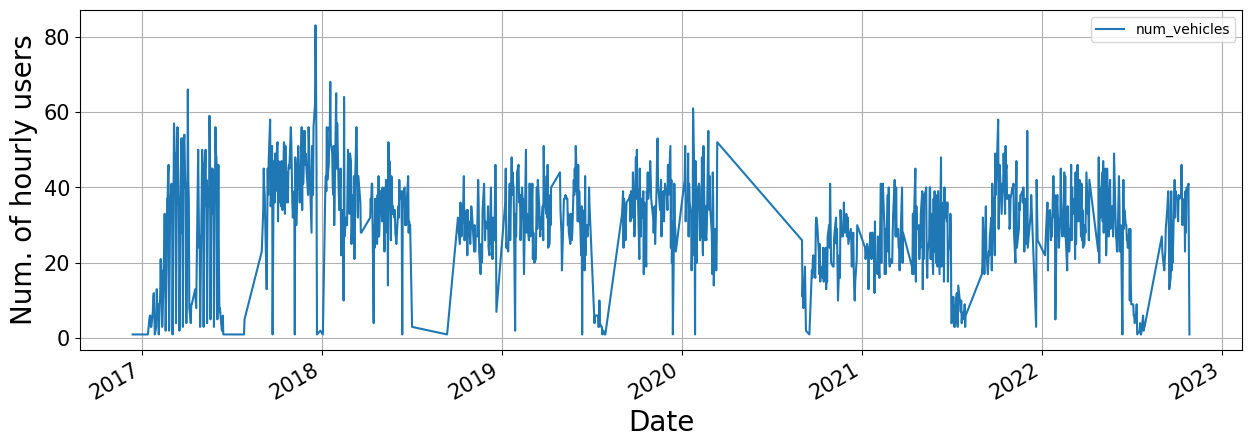

In [ ]:
ax=n_incoming_veh_df.plot(figsize=(15,5), grid=True)
ax.set_xlabel('Date',fontsize=20);
ax.set_ylabel('Num. of hourly users',fontsize=20);
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
n_incoming_veh_df['num_vehicles'] = scaler.fit_transform(n_incoming_veh_df[['num_vehicles']])

# Crear los datos de entrada y salida para la serie temporal
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 12  # Longitud de las secuencias
values = n_incoming_veh_df['num_vehicles'].values
X, y = create_sequences(values, sequence_length)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cambiar la forma de los datos para adaptarse a la entrada CNN-LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Definir el modelo CNN-LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=False),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Configuración de EarlyStopping
early_stopping = EarlyStopping(
    monitor="val_loss",  # Métrica que se monitorea
    patience=10,         # Número de épocas de espera sin mejoras antes de detener
    restore_best_weights=True,  # Restaurar los mejores pesos
    verbose=1          # Mostrar mensajes
)

# Entrenar el modelo
#history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Entrenamiento con EarlyStopping
model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],  # Incluir el callback
    verbose=1
)


# Evaluar el modelo
loss = model.evaluate(X_test, y_test)
print(f"Pérdida en el conjunto de prueba: {loss}")

# Hacer predicciones
y_pred = model.predict(X_test)

# Desescalar los resultados para obtener valores originales
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred)

print(f"Valores originales predichos: {y_pred_rescaled[:5].flatten()}")

Epoch 1/100
53/53 [==============================] - 1s 11ms/step - loss: 0.0469 - val_loss: 0.0215
Epoch 2/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0204 - val_loss: 0.0212
Epoch 3/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0201 - val_loss: 0.0213
Epoch 4/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0206 - val_loss: 0.0212
Epoch 5/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0202 - val_loss: 0.0211
Epoch 6/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0204 - val_loss: 0.0212
Epoch 7/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0200 - val_loss: 0.0214
Epoch 8/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0210 - val_loss: 0.0214
Epoch 9/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0201 - val_loss: 0.0216
Epoch 10/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0201 - val_loss: 0.0232
Epoch 11

In [ ]:
import requests
import pandas as pd

# Función para obtener datos horarios históricos de Open-Meteo API
def get_historical_weather_hourly(latitude, longitude, start_date, end_date):
    """
    Obtiene datos horarios históricos de Open-Meteo API.

    Args:
    - latitude (float): Latitud de la ubicación.
    - longitude (float): Longitud de la ubicación.
    - start_date (str): Fecha de inicio en formato YYYY-MM-DD.
    - end_date (str): Fecha de fin en formato YYYY-MM-DD.
    - parameters (list): Variables meteorológicas a consultar, ej. ['temperature_2m', 'humidity_2m'].

    Returns:
    - pd.DataFrame: Datos meteorológicos horarios como DataFrame.
    """
    base_url = "https://archive-api.open-meteo.com/v1/archive"


    # Crear el payload para la solicitud
    payload = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": 'temperature_2m',
        "timezone": "auto"
    }

    # Realizar la solicitud a la API
    response = requests.get(base_url, params=payload)

    if response.status_code == 200:
        # Convertir la respuesta JSON a un DataFrame
        data = response.json()
        if "hourly" in data:
            df = pd.DataFrame(data["hourly"])

            return df
        else:
            print("No se encontraron datos en la respuesta.")
            return pd.DataFrame()
    else:
        print(f"Error en la solicitud: {response.status_code} - {response.text}")
        return pd.DataFrame()

ambient_temperatures_df = get_historical_weather_hourly(park.coords_data['latitude'].iloc[0], park.coords_data['longitude'].iloc[0], init_date, final_date)
ambient_temperatures_df

NameError: name 'init_date' is not defined

In [ ]:
ambient_temperatures_df['time'] = pd.to_datetime(ambient_temperatures_df['time'])

ambient_temperatures_df= ambient_temperatures_df.set_index('time')
ambient_temperatures_df